In [ ]:
import multiprocessing
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from model_checkpoint import model_checkpoint

### Utility functions

In [2]:
def print_length_correlation(data):
        print("input_ids -", len(data["input_ids"]))
        print("attention_mask -", len(data["attention_mask"]))
        print("labels -", len(data["labels"]))

### Data preprocessing

In [3]:
# loading the dataset
PII = load_dataset("ai4privacy/pii-masking-400k")

# extracting English data points
cores = multiprocessing.cpu_count()

# how to run them concurrently?
PII = PII.filter(lambda example: example["language"] == "en", num_proc = cores)

# remove unnecessary columns
PII = PII.remove_columns(["locale", "language", "split", "uid"])

In [4]:
PII

DatasetDict({
    train: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes'],
        num_rows: 68275
    })
    validation: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes'],
        num_rows: 17046
    })
})

### Exploratory data analysis

In [5]:
def count_classes():
    classes = {}

    for row in PII["train"]:
        for value in row["privacy_mask"]:
            if value["label"] not in classes.keys():
                classes[value["label"]] = 1
            else:
                classes[value["label"]] += 1

    return classes

In [6]:
def show_class_distribution(classes):
    keys = classes.keys()
    counts = classes.values()

    plt.figure(figsize=(35, 10))
    plt.bar(keys, counts, color="black")

    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('Class Distribution')

    plt.show()

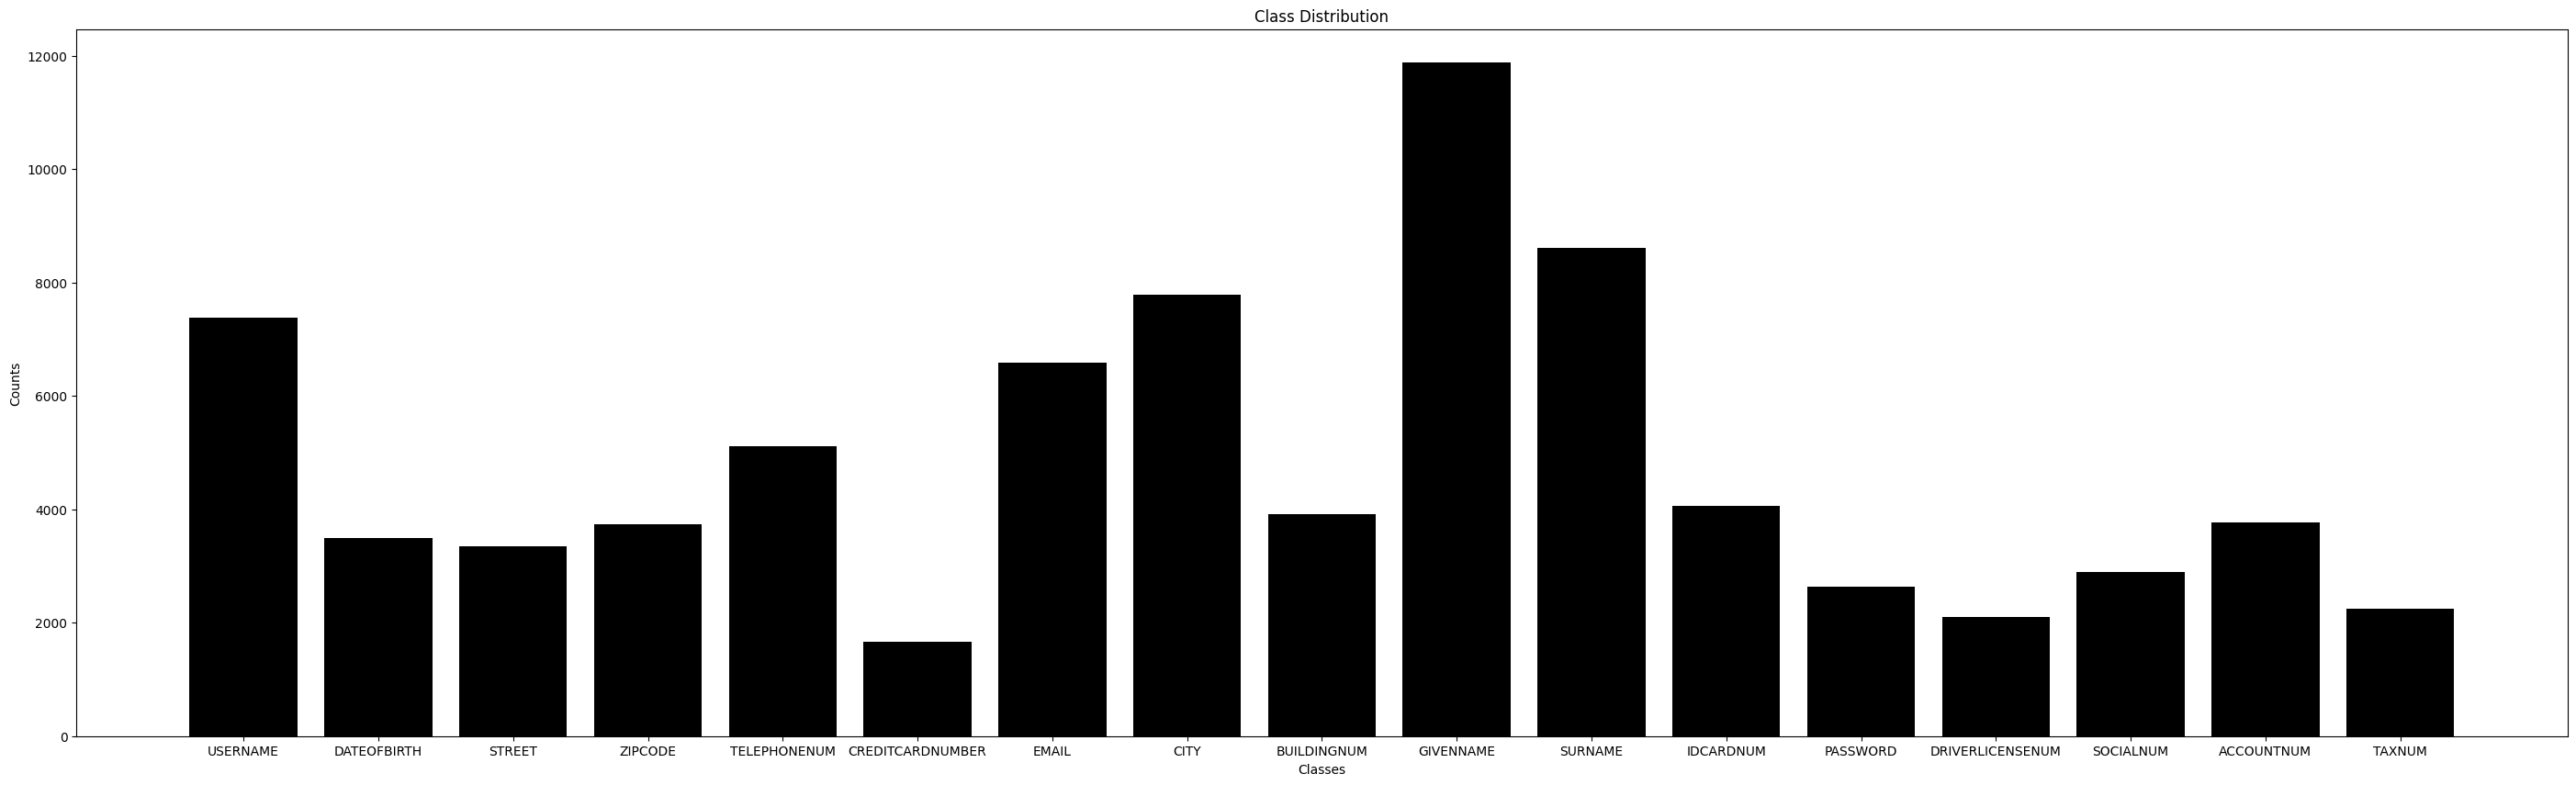

In [7]:
show_class_distribution(count_classes())

In [8]:
# shuffle the train dataset
PII = PII.shuffle(seed=33)

# reduce the train and validation datasets down to approx. 27000 training data points and approx. 12000 validation data points
select_train = int(0.40 * len(PII["train"]))
select_validation = int(0.70 * len(PII["validation"]))
PII["train"] = PII["train"].select(range(select_train))
PII["validation"] = PII["validation"].select(range(select_validation))

In [9]:
PII

DatasetDict({
    train: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes'],
        num_rows: 27310
    })
    validation: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes'],
        num_rows: 11932
    })
})

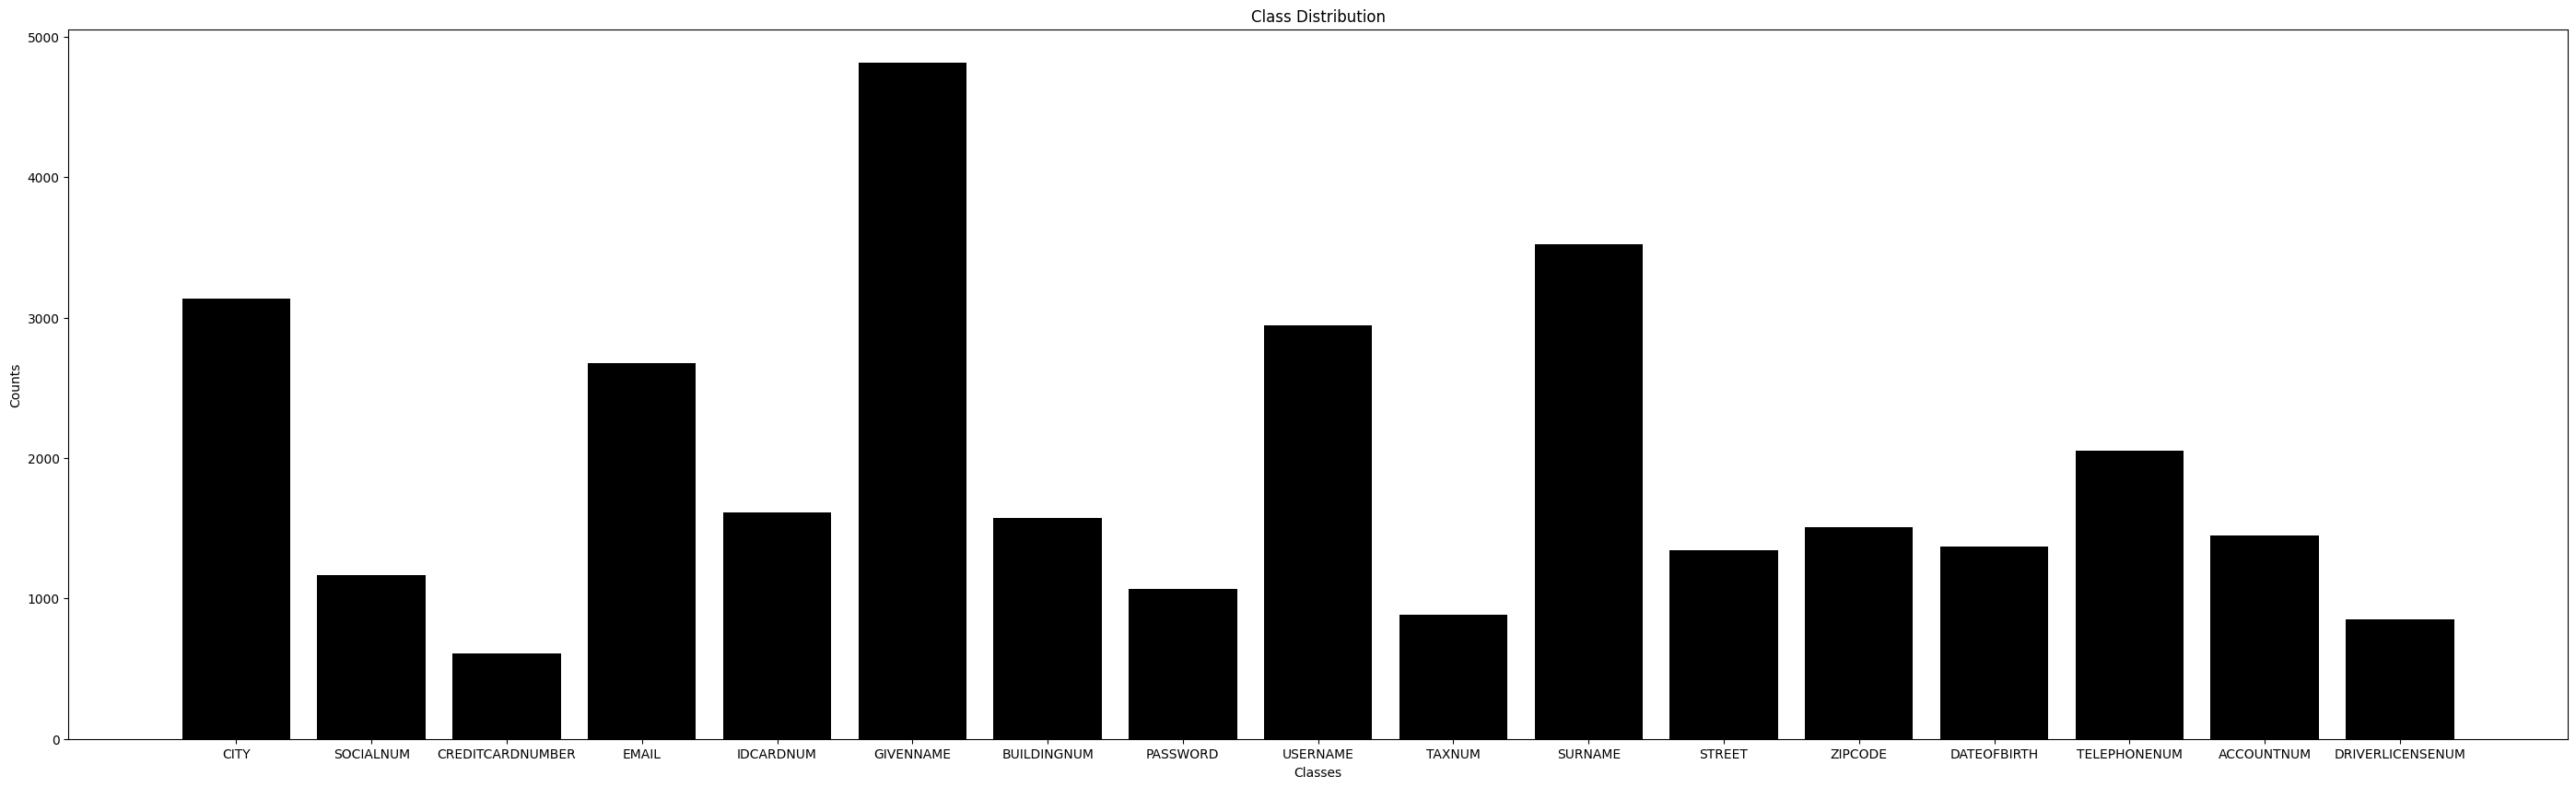

In [10]:
show_class_distribution(count_classes())

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Adding special tokens([CLS] and [SEP]) to "mbert_tokens"

In [12]:
def add_special_tokens(example):
    example["mbert_tokens"].insert(0, "[CLS]")
    example["mbert_tokens"].append("[SEP]")
    return example

PII = PII.map(add_special_tokens)

In [13]:
print(PII["train"][0]["mbert_tokens"])

['[CLS]', 'Our', 'detailed', 'strategy', 'for', 'Here', '##ford', 'E', '##wy', '##as', 'Harold', 'market', 'entry', 'discuss', '##es', 'sec', '##uring', 'funds', 'through', 'GB', '##47', 'L', '##Z', '##B', '##Z', '9', '##P', '##9', '##H', 'PIB', '##9', 'CS', '##VA', 'B', '##W', 'and', 'demo', '##graphic', 'studies', 'veri', '##fied', 'via', '141', '.', '174', '.', '591', '##4', '.', 'We', 'focus', 'on', '27', 'Female', 'groups', ',', 'ens', '##uring', 'secure', '[', 'IP', '##V', '##6', '_', '1', ']', 'transaction', '##s', 'for', '621', '##8', '##48', '##26', '##12', '##53', '##66', '##13', 'ex', '##pend', '##itur', '##es', '.', '[SEP]']


### Creating "input_ids" for "mbert_tokens"

In [14]:
def create_ids(example):
    example["input_ids"] = tokenizer.convert_tokens_to_ids(example["mbert_tokens"])
    return example

PII = PII.map(create_ids)

In [15]:
print(PII["train"][0]["input_ids"])
print(PII["train"][0]["mbert_tokens"])

[101, 3458, 6448, 5564, 1111, 3446, 2821, 142, 17953, 2225, 6587, 2319, 3990, 6265, 1279, 100, 6660, 4381, 1194, 17909, 24766, 149, 5301, 2064, 5301, 130, 2101, 1580, 3048, 100, 1580, 24821, 12152, 139, 2924, 1105, 11238, 11293, 2527, 100, 8971, 2258, 16308, 119, 21223, 119, 100, 1527, 119, 1284, 2817, 1113, 1765, 9714, 2114, 117, 100, 6660, 5343, 164, 14274, 2559, 1545, 168, 122, 166, 13618, 1116, 1111, 100, 1604, 19203, 25129, 11964, 24239, 100, 17668, 4252, 100, 100, 1279, 119, 102]
['[CLS]', 'Our', 'detailed', 'strategy', 'for', 'Here', '##ford', 'E', '##wy', '##as', 'Harold', 'market', 'entry', 'discuss', '##es', 'sec', '##uring', 'funds', 'through', 'GB', '##47', 'L', '##Z', '##B', '##Z', '9', '##P', '##9', '##H', 'PIB', '##9', 'CS', '##VA', 'B', '##W', 'and', 'demo', '##graphic', 'studies', 'veri', '##fied', 'via', '141', '.', '174', '.', '591', '##4', '.', 'We', 'focus', 'on', '27', 'Female', 'groups', ',', 'ens', '##uring', 'secure', '[', 'IP', '##V', '##6', '_', '1', ']', 'tr

### Creating attention masks

In [16]:
def create_attention_masks(example):
    example["attention_mask"] = [1] * (len(example["mbert_tokens"]))
    return example

PII = PII.map(create_attention_masks)

In [17]:
PII

DatasetDict({
    train: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes', 'input_ids', 'attention_mask'],
        num_rows: 27310
    })
    validation: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes', 'input_ids', 'attention_mask'],
        num_rows: 11932
    })
})

### Getting available NER classes and assigning unique NER class IDs

In [18]:
ner_classes = []
ner_ids = {}
ID = 0

# getting available NER classes
for row in PII["train"]:
   for token_class in row["mbert_token_classes"]:
      if token_class not in ner_classes:
         ner_classes.append(token_class)

# assigning unique IDs
for ner_class in ner_classes:
   ner_ids[ner_class] = None

for ner_class in ner_ids.keys():
   ner_ids[ner_class] = ID
   ID+=1

In [19]:
print(ner_classes)
print(ner_ids)

['O', 'B-CITY', 'I-CITY', 'B-SOCIALNUM', 'I-SOCIALNUM', 'B-CREDITCARDNUMBER', 'I-CREDITCARDNUMBER', 'B-EMAIL', 'I-EMAIL', 'B-IDCARDNUM', 'I-IDCARDNUM', 'B-GIVENNAME', 'I-GIVENNAME', 'B-BUILDINGNUM', 'B-PASSWORD', 'I-PASSWORD', 'B-USERNAME', 'I-USERNAME', 'B-TAXNUM', 'I-TAXNUM', 'B-SURNAME', 'I-SURNAME', 'B-STREET', 'I-STREET', 'B-ZIPCODE', 'I-ZIPCODE', 'B-DATEOFBIRTH', 'I-DATEOFBIRTH', 'B-TELEPHONENUM', 'I-TELEPHONENUM', 'B-ACCOUNTNUM', 'I-ACCOUNTNUM', 'B-DRIVERLICENSENUM', 'I-DRIVERLICENSENUM', 'I-BUILDINGNUM']
{'O': 0, 'B-CITY': 1, 'I-CITY': 2, 'B-SOCIALNUM': 3, 'I-SOCIALNUM': 4, 'B-CREDITCARDNUMBER': 5, 'I-CREDITCARDNUMBER': 6, 'B-EMAIL': 7, 'I-EMAIL': 8, 'B-IDCARDNUM': 9, 'I-IDCARDNUM': 10, 'B-GIVENNAME': 11, 'I-GIVENNAME': 12, 'B-BUILDINGNUM': 13, 'B-PASSWORD': 14, 'I-PASSWORD': 15, 'B-USERNAME': 16, 'I-USERNAME': 17, 'B-TAXNUM': 18, 'I-TAXNUM': 19, 'B-SURNAME': 20, 'I-SURNAME': 21, 'B-STREET': 22, 'I-STREET': 23, 'B-ZIPCODE': 24, 'I-ZIPCODE': 25, 'B-DATEOFBIRTH': 26, 'I-DATEOFBIR

### Creating labels for NER classes

In [20]:
def create_label_list(token_classes):
    labels = []
    for token_class in token_classes:
        labels.append(ner_ids[token_class])
    return labels

def create_labels(example):
    example["labels"] = create_label_list(example["mbert_token_classes"])
    return example

PII = PII.map(create_labels)

In [21]:
PII

DatasetDict({
    train: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 27310
    })
    validation: Dataset({
        features: ['source_text', 'privacy_mask', 'masked_text', 'mbert_tokens', 'mbert_token_classes', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11932
    })
})

In [22]:
print_length_correlation(PII["train"][0])

input_ids - 83
attention_mask - 83
labels - 81


In [23]:
def add_special_labels(example):
    example["labels"].insert(0, -100)
    example["labels"].append(-100)
    return example

PII = PII.map(add_special_labels)

In [24]:
print_length_correlation(PII["train"][0])

input_ids - 83
attention_mask - 83
labels - 83


In [25]:
# find the longest input_id

def find_longest_id(data):
    max_length = 0
    for row in data["input_ids"]:
        if len(row) > max_length:
            max_length = len(row)
    return max_length

In [26]:
longest_id = find_longest_id(PII["train"])
longest_validation_id = find_longest_id(PII["validation"]) 
if longest_id < longest_validation_id:
    longest_id = longest_validation_id 

In [27]:
def pad(examples):
    max_length = longest_id
    return tokenizer.pad(examples, padding="max_length", max_length=max_length) 

PII = PII.map(pad, batched=True)

Map: 100%|██████████| 11932/11932 [00:04<00:00, 2814.41 examples/s]


In [28]:
print("input_ids -", PII["train"][0]["input_ids"])
print("attention_mask -", PII["train"][0]["attention_mask"])

input_ids - [101, 3458, 6448, 5564, 1111, 3446, 2821, 142, 17953, 2225, 6587, 2319, 3990, 6265, 1279, 100, 6660, 4381, 1194, 17909, 24766, 149, 5301, 2064, 5301, 130, 2101, 1580, 3048, 100, 1580, 24821, 12152, 139, 2924, 1105, 11238, 11293, 2527, 100, 8971, 2258, 16308, 119, 21223, 119, 100, 1527, 119, 1284, 2817, 1113, 1765, 9714, 2114, 117, 100, 6660, 5343, 164, 14274, 2559, 1545, 168, 122, 166, 13618, 1116, 1111, 100, 1604, 19203, 25129, 11964, 24239, 100, 17668, 4252, 100, 100, 1279, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
print_length_correlation(PII["train"][0])

input_ids - 486
attention_mask - 486
labels - 83


In [30]:
def pad_labels(example):
    labels_len = len(example["labels"])
    input_ids_len = len(example["input_ids"]) 
    if labels_len < input_ids_len:
        for i in range(input_ids_len - labels_len):
            example["labels"].append(-100) 
    return example

PII = PII.map(pad_labels)

Map: 100%|██████████| 11932/11932 [00:06<00:00, 1962.83 examples/s]


In [31]:
print("labels -", PII["train"][0]["labels"])
print("input_ids -", PII["train"][0]["input_ids"])
print("attention_mask -", PII["train"][0]["attention_mask"])

labels - [-100, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [32]:
print_length_correlation(PII["train"][0])

input_ids - 486
attention_mask - 486
labels - 486


In [33]:
label2id = ner_ids
print(label2id)

{'O': 0, 'B-CITY': 1, 'I-CITY': 2, 'B-SOCIALNUM': 3, 'I-SOCIALNUM': 4, 'B-CREDITCARDNUMBER': 5, 'I-CREDITCARDNUMBER': 6, 'B-EMAIL': 7, 'I-EMAIL': 8, 'B-IDCARDNUM': 9, 'I-IDCARDNUM': 10, 'B-GIVENNAME': 11, 'I-GIVENNAME': 12, 'B-BUILDINGNUM': 13, 'B-PASSWORD': 14, 'I-PASSWORD': 15, 'B-USERNAME': 16, 'I-USERNAME': 17, 'B-TAXNUM': 18, 'I-TAXNUM': 19, 'B-SURNAME': 20, 'I-SURNAME': 21, 'B-STREET': 22, 'I-STREET': 23, 'B-ZIPCODE': 24, 'I-ZIPCODE': 25, 'B-DATEOFBIRTH': 26, 'I-DATEOFBIRTH': 27, 'B-TELEPHONENUM': 28, 'I-TELEPHONENUM': 29, 'B-ACCOUNTNUM': 30, 'I-ACCOUNTNUM': 31, 'B-DRIVERLICENSENUM': 32, 'I-DRIVERLICENSENUM': 33, 'I-BUILDINGNUM': 34}


In [34]:
id2label = {}
for value, key in enumerate(ner_ids):
    id2label[value] = key

print(id2label)

{0: 'O', 1: 'B-CITY', 2: 'I-CITY', 3: 'B-SOCIALNUM', 4: 'I-SOCIALNUM', 5: 'B-CREDITCARDNUMBER', 6: 'I-CREDITCARDNUMBER', 7: 'B-EMAIL', 8: 'I-EMAIL', 9: 'B-IDCARDNUM', 10: 'I-IDCARDNUM', 11: 'B-GIVENNAME', 12: 'I-GIVENNAME', 13: 'B-BUILDINGNUM', 14: 'B-PASSWORD', 15: 'I-PASSWORD', 16: 'B-USERNAME', 17: 'I-USERNAME', 18: 'B-TAXNUM', 19: 'I-TAXNUM', 20: 'B-SURNAME', 21: 'I-SURNAME', 22: 'B-STREET', 23: 'I-STREET', 24: 'B-ZIPCODE', 25: 'I-ZIPCODE', 26: 'B-DATEOFBIRTH', 27: 'I-DATEOFBIRTH', 28: 'B-TELEPHONENUM', 29: 'I-TELEPHONENUM', 30: 'B-ACCOUNTNUM', 31: 'I-ACCOUNTNUM', 32: 'B-DRIVERLICENSENUM', 33: 'I-DRIVERLICENSENUM', 34: 'I-BUILDINGNUM'}


In [35]:
tokenizer.save_pretrained("./preprocessing_tokenizer")

('./preprocessing_tokenizer\\tokenizer_config.json',
 './preprocessing_tokenizer\\special_tokens_map.json',
 './preprocessing_tokenizer\\vocab.txt',
 './preprocessing_tokenizer\\added_tokens.json',
 './preprocessing_tokenizer\\tokenizer.json')

In [36]:
PII.save_to_disk("./dataset")

Saving the dataset (1/1 shards): 100%|██████████| 11932/11932 [00:00<00:00, 197530.15 examples/s]
